**ConcertAI Techtest** <br>
**Author**: Vinay Barnabas

*Tech Stack*: VSCode + Jupyter Notebooks <br>
*Presentation*: Jupyter Notebooks <br>
*Version Control*: Git <br>
*Github repository*: https://github.com/VinylBr/InterviewTechTestSol <br>
*App link*: https://vinylbr-interviewtechtestsol-app-bc-ds9ega.streamlit.app/


In [277]:
# importing necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns #plotting
import matplotlib.pyplot as plt #plotting
from lifelines import KaplanMeierFitter #survival analysis
from lifelines.statistics import logrank_test #statistical test in survival analysis
from lifelines.utils import median_survival_times #summary statistic for median survival times
from datetime import datetime

# muting FutureWarnings. These are warnings about features that will be removed in a future version
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

*Plotting conventions for the notebook*

In [278]:
# define plot style
def set_plot_style():
    '''
    function to set figure parameters
    Inputs: None
    Return: None
    '''

    # define style: plots will not have gridlines. X- and y- ticks would be present
    sns.set_style('ticks')

    # parameter to control scaling of plot elements.
    sns.set_context('notebook')

    # fix figure parameters
    plt.rcParams['figure.figsize'] = (10,6)
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['lines.linewidth'] = 2
    
    # fix color palette
    sns.set_palette('muted')

def frame_off(ax):
    '''
    function to remove outer frame in plots
    Inputs: ax = plot axes
    Return: Nothing
    '''
    for _, spines in ax.spines.items():
        spines.set_visible(False)


# fix figure paraeters by calling the function
set_plot_style()

## Data Exploration and Cleaning

In [279]:
# Establish connection to sqlite3 database and define a cursor
con = sqlite3.connect("techTest.db")
cur = con.cursor()

In [280]:
# query to extract table info from sqlite_master
sql_master_query = '''--sql
                SELECT name
                FROM sqlite_master
                WHERE type = "table";
            '''
# Execute the query and fetchall the results
cur.execute(sql_master_query)
list_table_info = cur.fetchall()

cols_pragma = ["index", "name", "data_type", "notnull", "default_value", "primary_key"] #from PRAGMA info

# for each table display PRAGMA table information
for item in list_table_info:
    # get number of rows for each table
    sql_row_query = f"""--sql
                      SELECT COUNT(*) 
                      FROM {item[0]};
                      """
    cur.execute(sql_row_query)
    num_rows = cur.fetchone()[0] # [0] is to obtain the first element of the output tuple
    print(f"Table {item[0]} with {num_rows} rows")
    
    # get number of columns, their names, type, whether NULL is allowed, whether primary key
    sql_column_query = f"PRAGMA table_info({item[0]})"
    cur.execute(sql_column_query)
    column_info = cur.fetchall()

    # create a dataframe for each column info
    df_temp = pd.DataFrame(column_info, columns = cols_pragma).set_index("index")
    print(df_temp)

    print(50*"-")
    print("\n")

Table patient with 1000 rows
             name  data_type  notnull default_value  primary_key
index                                                           
0      patient_id       TEXT        0          None            0
1             dob  TIMESTAMP        0          None            0
2             dod  TIMESTAMP        0          None            0
3          gender       TEXT        0          None            0
--------------------------------------------------


Table diagnosis with 3026 rows
                      name  data_type  notnull default_value  primary_key
index                                                                    
0               patient_id       TEXT        0          None            0
1           diagnosis_date  TIMESTAMP        0          None            0
2           diagnosis_code       TEXT        0          None            0
3      diagnosis_code_type       TEXT        0          None            0
--------------------------------------------------




**OBSERVATION**: <br>
- Tables diagnosis and biomarkers have more than 1000 records since each patient_id has multiple diagnosis dates and biomarker test dates
- patient_id can be used as a key to join the three tables

### Sanity Checks


*Is date of birth later than date of death?*

In [281]:
# query to count number of patients where date of birth is later than date of death
sql_query = '''--sql
            
            SELECT COUNT(*)
            FROM Patient
            WHERE dob > dod
            
            ;'''

cur.execute(sql_query)

# assert statement returns an error if False
assert cur.fetchall()[0][0] == 0, "Date of Birth is later than Date of death"

*Is date of death later than 2024?*

In [282]:
#query to identify patients whose year of death is later than 2024
sql_death_query = '''--sql
            
                    SELECT COUNT(*)
                    FROM patient
                    ---converting dod to year format and comparing to 2024--- 
                    WHERE STRFTIME("%Y",dod) > STRFTIME("%Y","now");
                
                '''
cur.execute(sql_death_query)

num_dodbiggernow = cur.fetchone()[0]

print(f"Number of records in Patient table where date of death is later than current date: {num_dodbiggernow}")

Number of records in Patient table where date of death is later than current date: 174


*Is date of death earlier than earliest date of diagnosis?*

I plot distributions of 
1. DOD - earliest date of diagnosis
2. DOD - latest date of diagnosis

Here, <br>
earliest date of diagnosis = MIN(diagnosis_date) for a patient <br>
latest date of diagnosis = MAX(diagnosis_date) for a patient <br>


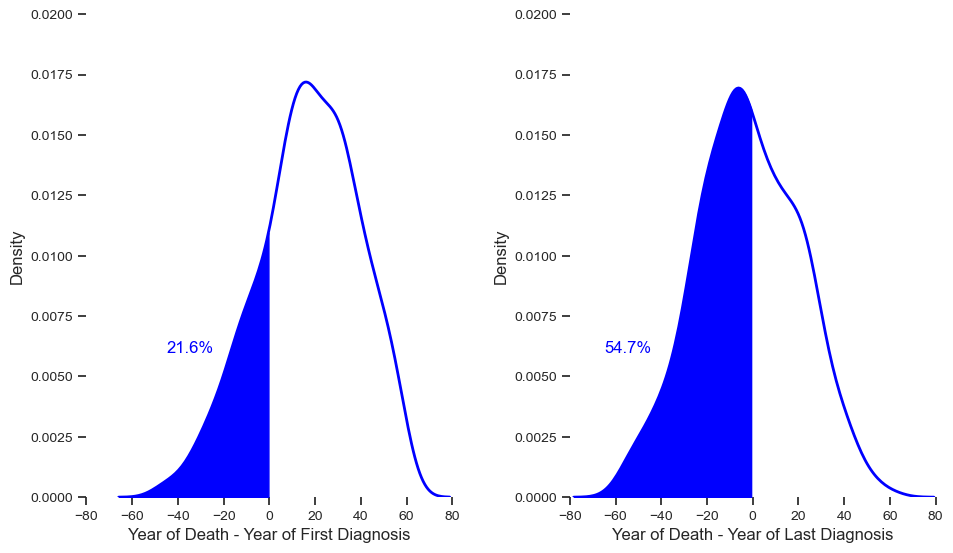

In [283]:
#query to calculate difference between date of death (dod) and the date of first diagnosis and dod and the date of last diagnosis
query = '''--sql
            SELECT 
                STRFTIME("%Y", p.dod) - STRFTIME("%Y",MIN(d.diagnosis_date)) as dod_firstdiagnosis, 
                STRFTIME("%Y", p.dod) - STRFTIME("%Y",MAX(d.diagnosis_date)) as dod_lastdiagnosis
            
            ---LEFT JOIN Patient and Diagnosis table on key patient_id---
            FROM 
                Patient as p 
            LEFT JOIN 
                Diagnosis as d 
                    ON p.patient_id = d.patient_id 
            
            WHERE 
                d.diagnosis_code LIKE "C50%"
            
            GROUP BY 
                p.patient_id
        
            ;
        '''

# generating a dataframe using sqlquery
df_dod_diagnosis = pd.read_sql_query(query, con)

# plot distribution of (dod - date of firstdiagnosis) and (dod - date of lastdiagnosis)
fig, ax = plt.subplots(1,2)
kde_dod_firstdiagnosis = sns.kdeplot(df_dod_diagnosis, 
                                     x = "dod_firstdiagnosis",
                                     color = "b", 
                                     ax = ax[0])

kde_dod_lastdiagnosis = sns.kdeplot(df_dod_diagnosis, 
                                    x = "dod_lastdiagnosis",
                                    color = "b", 
                                    ax = ax[1])


# shade the area under kdeplot where difference (dod - date of first diagnosis) and (dod - date of last diagnosis) is negative
l1 = kde_dod_firstdiagnosis.lines[0]
l2 = kde_dod_lastdiagnosis.lines[0]
# get x and y coordinates of kernel-density function
x1, y1 = l1.get_xydata()[:,0], l1.get_xydata()[:,1]
x2, y2 = l2.get_xydata()[:,0], l2.get_xydata()[:,1]

# fill area using x and y coordinates
kde_dod_firstdiagnosis.fill_between(x1, y1, 
                                    where = x1<=0, #where x-axis is negative
                                    color = "b")
kde_dod_lastdiagnosis.fill_between(x2, y2, 
                                   where = x2<=0, #where x-axis is negative
                                   color = "b")

# label the shaded area which is the fraction of cases where difference is negative
x_pos_first, y_pos_first = -45, 0.006
x_pos_last, y_pos_last = -65, 0.006
ax[0].text(x_pos_first, y_pos_first, f"{100*(df_dod_diagnosis['dod_firstdiagnosis'] < 0).mean():0.1f}%", color = "b")
ax[1].text(x_pos_last, y_pos_last, f"{100*(df_dod_diagnosis['dod_lastdiagnosis'] < 0).mean():0.1f}%", color = "b")

# provide axes labels set their limits
ax[0].set_xlabel("Year of Death - Year of First Diagnosis")
ax[1].set_xlabel("Year of Death - Year of Last Diagnosis")
ax[0].set_xlim([-80, 80])
ax[0].set_ylim([0, 0.02])
ax[1].set_xlim([-80, 80])
ax[1].set_ylim([0, 0.02])
# remove the frames for both axes
frame_off(ax[0])
frame_off(ax[1])

# increase padding between the subplots
fig.tight_layout(pad = 2)

**OBSERVATIONS**: <br>
1. More than 50% of patients have date of death sooner than date of last diagnosis
2. More than 20% of patients have date of death sooner than date of first diagnosis 

In [284]:
#c close the connection to the sqlite database
con.close()

Approach: <br>
----

**Assumptions**: <br> <br>
Assume that diagnosis_dates and biomarker_test_dates are more reliable than date of death column. 

Patients where date of death < (date of diagnosis, biomarker test dates); set the date of death to NA <br>
<br>
Patient where date of death > (date of diagnosis, biomarker test dates); accept date of death <br> <br>

**Definitions**: <br> <br>

_date_first_diagnosis_ = MIN(diagnosis_date (only BC)) <br>

_Follow-up time_ =  date_first_diagnosis - Max(diagnosis_date (all), biomarker_test_date (all), date of death) <br>

_Age at diagnosis_ = date_first_diagnosis - DOB





## Data maturity 
1. Calculate the summary statistics and plot the distribution of follow up time for BC patients.
2. Calculate the summary statistics and plot the distribution of age at initial diagnosis for BC patients

In [285]:
#connect to the sqlite database
con = sqlite3.connect("techTest.db")
cur = con.cursor()

query_patient = '''--sql
                SELECT 
                    p.patient_id as patient_id, 
                    date(p.dod) as dod,  
                    STRFTIME("%Y", MIN(d.diagnosis_date)) - STRFTIME("%Y",p.dob) as age_at_diagnosis, 
                    date(MIN(d.diagnosis_date)) as first_diagnosis_date, 
                    sub_dates.last_diagnosis_date as last_diagnosis_date, 
                    sub_dates.last_test_date as last_test_date

                ---Patient joined to Diagnosis---
                FROM 
                    patient as p 
                LEFT JOIN 
                    diagnosis as d
                        ON p.patient_id = d.patient_id

                ---Left JOIN to sub-query that calculates last_diagnosis_date and last_test_date---
                ---last_diagnosis_date and last_test_date are calculated without considered BC status---
                ---This is because last encounter in the database should be disease independent---                        
                LEFT JOIN
                    (SELECT 
                        sub_p.patient_id, 
                        date(MAX(sub_d.diagnosis_date)) as last_diagnosis_date,
                        date(MAX(sub_b.test_date)) as last_test_date

                    FROM
                        patient as sub_p
                    LEFT JOIN
                        diagnosis as sub_d 
                            ON sub_p.patient_id = sub_d.patient_id
                    LEFT JOIN
                        biomarker as sub_b
                            ON sub_p.patient_id = sub_b.patient_id
                    
                    GROUP BY
                        sub_p.patient_id
                    ) as sub_dates
                        ON p.patient_id = sub_dates.patient_id 

                WHERE  
                    d.diagnosis_code LIKE "C50%"
                        
                GROUP BY 
                    p.patient_id;

                '''

df = pd.read_sql_query(query_patient, con)

print(f"Size of the table: {df.shape[0]} x {df.shape[1]}")
df.head(n = 10)

Size of the table: 941 x 6


,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date
0,0004477e-31f7-4704-a123-2b68dd64aaed,2008-03-20,59,2019-11-04,2019-11-04,2011-12-03
1,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,50,1993-04-07,2019-05-20,2004-12-19
2,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,21,1986-06-02,2021-10-13,2023-12-29
3,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,30,1996-10-05,2020-06-13,2018-03-10
4,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,26,1977-01-16,1981-10-28,1995-12-08
5,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,26,1956-06-03,2005-01-07,2021-07-29
6,023f0abd-4675-4b59-96e9-5b5ca052560a,2027-08-10,25,1991-07-11,2009-04-15,2014-06-08
7,02c9feee-9e65-499f-bb93-e8aa1aba0160,2013-10-16,27,1993-08-01,2020-12-05,2023-07-09
8,030f8523-82f4-44d0-bb76-e0cd71237b88,1967-09-18,45,1980-02-07,2003-09-09,1954-10-24
9,0337f270-8ffe-432f-99e4-64060cd2a360,2032-05-22,41,2007-09-02,2018-12-29,2017-06-11


*What about patients with a test date with a valid result that is lower than the first diagnosis date?*

In [286]:
# records where last_test_date is sooner than first_diagnosis_date
df_diagnostic_biomarker = df[df["last_test_date"] < df["first_diagnosis_date"]]

# biomarker table
df_biomarker = pd.read_sql("SELECT * FROM biomarker", con)


condition = df_biomarker["patient_id"].isin(df_diagnostic_biomarker["patient_id"])
positive_biomarker = (df_biomarker.loc[condition, "test_result"] == "Positive").sum()
print(f"Number of patients with the last test date sooner than the first diagnosis date: {positive_biomarker}")

Number of patients with the last test date sooner than the first diagnosis date: 76


Definition of first diagnosis is the first encounter in the diagnosis table. <br>
Biomarkers may be used to accompany biopsy testing and are not usually used as a diagnostic tool [1]

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   patient_id            941 non-null    object
 1   dod                   941 non-null    object
 2   age_at_diagnosis      941 non-null    int64 
 3   first_diagnosis_date  941 non-null    object
 4   last_diagnosis_date   941 non-null    object
 5   last_test_date        941 non-null    object
dtypes: int64(1), object(5)
memory usage: 44.2+ KB


*DOD that is later than today is set to today's date*

In [288]:
df_dod_mod = df.copy()

# Converting columns with date-time to pandas date-time
time_format_cols = ["first_diagnosis_date", "last_diagnosis_date", "last_test_date", "dod"]
for col in time_format_cols:
    df_dod_mod[col] = pd.to_datetime(df_dod_mod[col])

today = datetime(2024, 7, 1)
df_dod_mod.loc[df_dod_mod["dod"] > today, "dod"] = today
df_dod_mod.head()

,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date
0,0004477e-31f7-4704-a123-2b68dd64aaed,2008-03-20,59,2019-11-04,2019-11-04,2011-12-03
1,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,50,1993-04-07,2019-05-20,2004-12-19
2,0183e236-7892-4aa9-8b7f-10f12676f1ec,2024-07-01,21,1986-06-02,2021-10-13,2023-12-29
3,019d3689-e49a-4f23-8ca1-65379907230b,2024-07-01,30,1996-10-05,2020-06-13,2018-03-10
4,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,26,1977-01-16,1981-10-28,1995-12-08


*DOD that is sooner than either diagnosis dates of test_dates is set to NA*

In [289]:
def replace_dod(row):
    '''
    function to replace dod with NA if dod < diagnosis dates or test dates
    Input: row values
    Return: modified row value
    '''
    if (row["dod"] < row["first_diagnosis_date"]) | (row["dod"] < row["last_diagnosis_date"]) | (row["dod"] <  row["last_test_date"]):
        row["dod"] = np.nan
    
    return row["dod"]

df_dod_mod["dod"] = df_dod_mod.apply(replace_dod, axis = 1)
df_dod_mod.head()

,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date
0,0004477e-31f7-4704-a123-2b68dd64aaed,NaT,59,2019-11-04,2019-11-04,2011-12-03
1,0022fa14-8260-4b11-88cd-3fa066ede851,NaT,50,1993-04-07,2019-05-20,2004-12-19
2,0183e236-7892-4aa9-8b7f-10f12676f1ec,2024-07-01,21,1986-06-02,2021-10-13,2023-12-29
3,019d3689-e49a-4f23-8ca1-65379907230b,2024-07-01,30,1996-10-05,2020-06-13,2018-03-10
4,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,26,1977-01-16,1981-10-28,1995-12-08


**OBSERVATION**: <br>
NaT is "Not a Time". It is the equivalent of NA for date, time context in pandas

**Next Step**: <br>
Calculate the last_encounter_date

*last_encounter_date = MAX(dad, last_diagnosis_date, last_test_date)*

In [290]:
df_dod_mod["last_encounter_date"] = np.max(df_dod_mod[["last_diagnosis_date", "last_test_date", "dod"]], axis = 1)

df_dod_mod.head()

,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date
0,0004477e-31f7-4704-a123-2b68dd64aaed,NaT,59,2019-11-04,2019-11-04,2011-12-03,2019-11-04
1,0022fa14-8260-4b11-88cd-3fa066ede851,NaT,50,1993-04-07,2019-05-20,2004-12-19,2019-05-20
2,0183e236-7892-4aa9-8b7f-10f12676f1ec,2024-07-01,21,1986-06-02,2021-10-13,2023-12-29,2024-07-01
3,019d3689-e49a-4f23-8ca1-65379907230b,2024-07-01,30,1996-10-05,2020-06-13,2018-03-10,2024-07-01
4,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,26,1977-01-16,1981-10-28,1995-12-08,2007-07-30


*follow_up_time = (last_encounter_date - first-diagnosis date) in years*

In [291]:
# calculate follow-up_time in days, convert to years by dividing it by 365.25, and round the output to have 1 decimal place
df_dod_mod["follow_up_time"] = ((df_dod_mod["last_encounter_date"] - df_dod_mod["first_diagnosis_date"]).dt.days/365.25).round(1)

df_dod_mod.head()

,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date,follow_up_time
0,0004477e-31f7-4704-a123-2b68dd64aaed,NaT,59,2019-11-04,2019-11-04,2011-12-03,2019-11-04,0.0
1,0022fa14-8260-4b11-88cd-3fa066ede851,NaT,50,1993-04-07,2019-05-20,2004-12-19,2019-05-20,26.1
2,0183e236-7892-4aa9-8b7f-10f12676f1ec,2024-07-01,21,1986-06-02,2021-10-13,2023-12-29,2024-07-01,38.1
3,019d3689-e49a-4f23-8ca1-65379907230b,2024-07-01,30,1996-10-05,2020-06-13,2018-03-10,2024-07-01,27.7
4,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,26,1977-01-16,1981-10-28,1995-12-08,2007-07-30,30.5


**OBSERVATION**: <br>
Some patients have a follow-up time of 0 since they had only one encounter in the database <br>
These are patients who have only 1 encounter in the diagnosis table and no later encounter in the biomarker table

**NEXT STEPS**: <br>
1. Sanity check for number of patients with DOD lower than first diagnosis <br>
2. Sanity check for number of patients with DOD lower than last_diagnosis and test_dates <br>
3. Calculate the proportion of patients where follow-up time is 0


In [292]:
print(f"Number of patients with DOD < first diagnosis: {(df_dod_mod['dod'] < df_dod_mod['first_diagnosis_date']).sum()}")

print(f"""Number of patients with DOD < last_diagnosis and test_dates: {((df_dod_mod['dod'] < df_dod_mod['last_diagnosis_date'])
                                                                       |(df_dod_mod['dod'] < df_dod_mod['last_test_date']))
                                                                       .sum()}""")

Number of patients with DOD < first diagnosis: 0
Number of patients with DOD < last_diagnosis and test_dates: 0


In [293]:
# Calculate number of empty row-values in each column
df_dod_mod.isna().sum()

patient_id                0
dod                     656
age_at_diagnosis          0
first_diagnosis_date      0
last_diagnosis_date       0
last_test_date            0
last_encounter_date       0
follow_up_time            0
dtype: int64

In [294]:
print(f"fraction of patients with 0 follow_up time: {100*(df_dod_mod['follow_up_time']==0).mean(): 0.2f}%")
df_dod_mod[df_dod_mod["follow_up_time"]==0].head()

fraction of patients with 0 follow_up time:  5.53%


,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date,follow_up_time
0,0004477e-31f7-4704-a123-2b68dd64aaed,NaT,59,2019-11-04,2019-11-04,2011-12-03,2019-11-04,0.0
36,0b6096c4-9ffd-4a69-8257-3f94cf82fa45,NaT,56,1987-05-20,1987-05-20,1974-11-22,1987-05-20,0.0
71,15591b85-3176-4982-8a31-68684b140b31,NaT,76,2010-04-16,2010-04-16,1966-01-15,2010-04-16,0.0
81,188c9c32-5f88-4936-952f-358ad36d9cd6,NaT,70,2019-05-09,2019-05-09,2000-04-02,2019-05-09,0.0
114,2076ea86-235b-4639-9774-3c5c45d78942,NaT,61,1994-09-05,1994-09-05,1993-09-05,1994-09-05,0.0


In subsequent analysis, since these patients are not at risk any time, we ignore patients who have their follow-up time = 0

In [295]:
df_final = df_dod_mod[df_dod_mod["follow_up_time"]!=0].copy()

*Summary statistics for follow-up time and age_at_diagnosis*

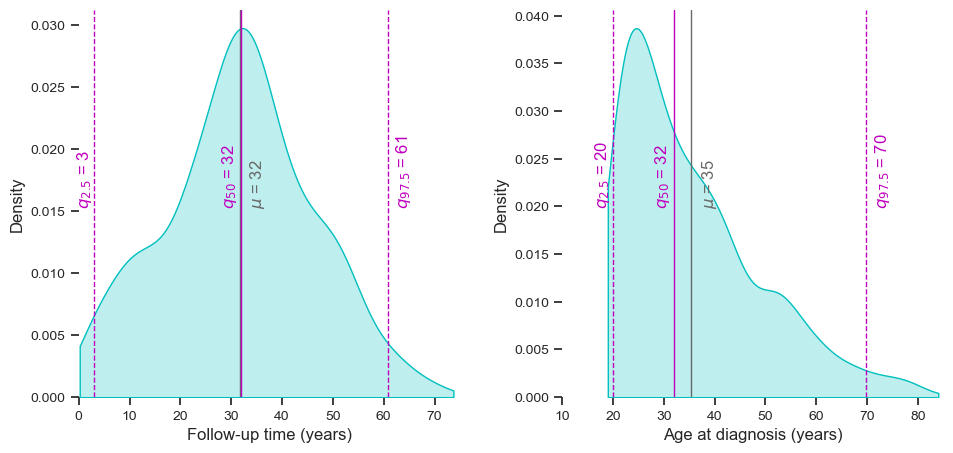

In [296]:
#Plot the distribution of follow_up_time and age_at_diagnosis
fig, axes = plt.subplots(1,2, figsize = (10,5))
dataframe = df_final

# kernel-density estimation plot for follow_up_time
x_follow_up_max = dataframe["follow_up_time"].max()
x_follow_up_min = dataframe["follow_up_time"].min()
p1 = sns.kdeplot(
    dataframe,
    x = "follow_up_time",
    fill = True,
    color = "c",
    clip = (x_follow_up_min,x_follow_up_max), # to remove artifacts of kernel-density estimation
    ax = axes[0]

)

# Kernel-density estimation plot for age_at_diagnosis
x_age_diagnosis_max = dataframe["age_at_diagnosis"].max()
x_age_diagnosis_min = dataframe["age_at_diagnosis"].min()
p2 = sns.kdeplot(
    dataframe,
    x = "age_at_diagnosis",
    fill = True,
    color = "c",
    clip = (x_age_diagnosis_min,x_age_diagnosis_max), # to remove artifacts of kernel-density estimations
    ax = axes[1]
)

# define x-axis labels
axes[0].set_xlabel("Follow-up time (years)")
axes[1].set_xlabel("Age at diagnosis (years)")
axes[0].set_xlim([0, 75])
axes[1].set_xlim([10, 85])

def summary_stats(x, ax):
    '''
        function to plot mean, median, and 2.5% and  97.5% quantile as vertical lines
        Input: ax = axes
               x = column name
        
        Return: nothing. plots vertical lines 
    '''
    # calculate summary statistics: mean, median, and interquantile range
    mu_x, med_x = dataframe[x].mean(), dataframe[x].median()
    alpha_x, oneminusalpha_x = dataframe[x].quantile(q = [0.025, 0.975])
    
    # calculate y-axis text label position
    y_limit_plot = ax.get_ylim()
    y_pos = np.mean(y_limit_plot)

    # plot mean and its text label
    ax.axvline(mu_x, lw = 1, color = "dimgray")
    ax.text(mu_x*1.05, y_pos, 
            f"$\mu$ = {np.round(mu_x,0):0.0f}", 
            horizontalalignment = "left", 
            rotation = "vertical", 
            color = "dimgray")
    
    # plot median and its label
    ax.axvline(med_x, lw = 1, color = "m")
    ax.text(med_x*0.99, y_pos, 
            f"$q_{{50}}$ = {np.round(med_x,0):0.0f}", 
            horizontalalignment = "right", 
            rotation = "vertical", 
            color = "m")
    
    # plot 2.5% quantile and its text label
    ax.axvline(alpha_x, lw = 1, ls = '--', color = "m")
    ax.text(alpha_x*0.99, y_pos, 
            f"$q_{{2.5}}$ = {np.round(alpha_x,0):0.0f}", 
            horizontalalignment = "right", 
            rotation = "vertical", 
            color = "m")
    
    # plot 97.5% quantile and its text label
    ax.axvline(oneminusalpha_x, lw = 1, ls = "--", color = "m")
    ax.text(oneminusalpha_x*1.02, y_pos, 
            f"$q_{{97.5}}$ = {np.round(oneminusalpha_x,0):0.0f}", 
            horizontalalignment = "left", 
            rotation = "vertical", 
            color = "m")

# summary vertical lines for mean, median, and 2.5% and 97.5% quantiles
summary_stats("follow_up_time", axes[0])
summary_stats("age_at_diagnosis", axes[1])

# increase padding between figures
fig.tight_layout(pad = 2)

# Remove the outerframe of each plot
frame_off(axes[0])
frame_off(axes[1])

plt.show()

**OBSERVATION**: <br> 
1. Follow-up time follows an almost symmetric distribution (mean = median). This is after removing patients whose follow-up time is 0. When patients with follow-up time of 0 were included there was a smaller peak at x = 0.
2. Age at diagnosis has a right-skewed distribution. 

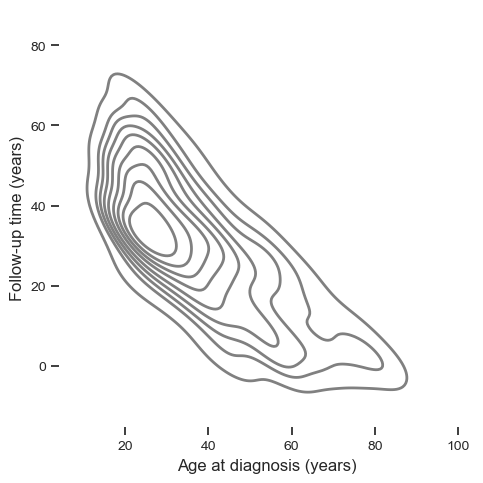

In [297]:
# Plotting distribution of age_at_diagnosis and follow_up_time
sns.displot(df_dod_mod, 
            x = "age_at_diagnosis", 
            y = "follow_up_time", 
            kind = "kde", 
            color = "gray")

# set axis labels
plt.xlabel("Age at diagnosis (years)")
plt.ylabel("Follow-up time (years)")

plt.box(False)
plt.show()

**OBSERVATIONS**: <br>
- As age at diagnosis increases, the follow-up time decreases 

In [298]:
# close the connection to the database
con.close()

## Survival Analysis

### Data Exploration

In [299]:
# For Survival Analysis
# Event has occured if, for a patient, date of deat (dod) is known
# a patient is censored if the last encounter in the database is either a diagnostic or biomarker test and the data of death is NA
df_final["status"] = df_final["dod"].notna().map({
                                                    True: "event",
                                                    False: "censor"
                                                })
print(f"Proportion of patients with a censored status: {100*df_final['status'].value_counts(normalize = True)['censor']:0.1f} %")

Proportion of patients with a censored status: 67.9 %


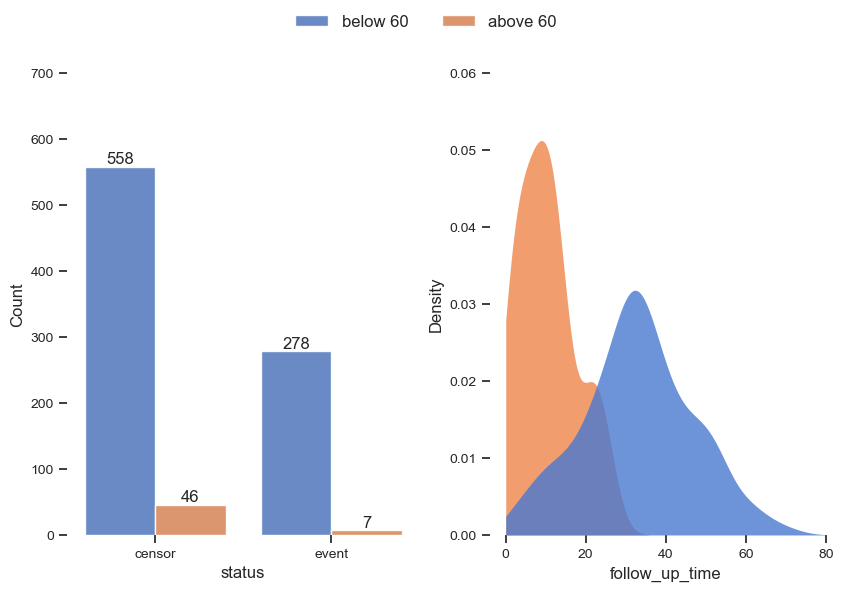

In [300]:
#age (in years) at diagnosis to stratify the patients
age_to_stratify = 60
mask = df_final["age_at_diagnosis"] > age_to_stratify
df_final["stratified_age"] = mask
df_final["stratified_age"] = df_final["stratified_age"].map({
                                                                True: "above",
                                                                False: "below"
                                                            })

custom_order = ["below", "above"]

fig, ax = plt.subplots(1,2)
k = sns.kdeplot(df_final, 
            x = "follow_up_time", 
            hue = "stratified_age", 
            hue_order = custom_order,
            fill = True, 
            common_norm = False, 
            clip = (0,80), # we clip the extremities to prevent artifacts by kernet density estimation
            alpha = 0.8,
            linewidth = 0,
            legend = False,
            ax = ax[1])



c = sns.countplot(df_final,
            x = "status",
            hue = "stratified_age",
            hue_order = custom_order,
            alpha = 0.9,
            ax = ax[0])

# label count values on top of each bar
for container in ax[0].containers:
    ax[0].bar_label(container)

# fix axes parameters
ax[0].legend_.remove()
ax[1].set_ylim([0, 0.06])
ax[0].set_ylim([0, 700])
ax[0].set_ylabel("Count")

# remove outer frame
frame_off(ax[1])
frame_off(ax[0])

# display a common legend
fig.legend([f"below {age_to_stratify}", f"above {age_to_stratify}"], 
           fontsize = 12, 
           frameon = False,
           loc = "upper center",
           ncols = len(ax))
plt.show()

**OBSERVATION**: <br>
- Only 6% of the patients were over 60 at the time of diagnosis
- Hence, number of events (death) for patients who were over 60 at time of diagnosis is also skewed: ~40 times lower than for patients above 60
- Follow-up times for patients who were over 60 at the time of diagnosis is much lower than the other group

### Kaplan Meier Plots

Kaplan Meier (KM) plots present $S(t) = Pr(T>t)$, where $Pr(T>t)$ is the probability of a patient surviving for time greater than t <br>
Here, I plot KM plots using Kaplan-Meier fitter from the lifelines package using follow-up times and status of each patient. <br><br>
Status = 1, implying death, if a patient's date of death is the last encounter in the database <br>
Status = 0, implying censored, if a patient's date of death is lower than the last encounter


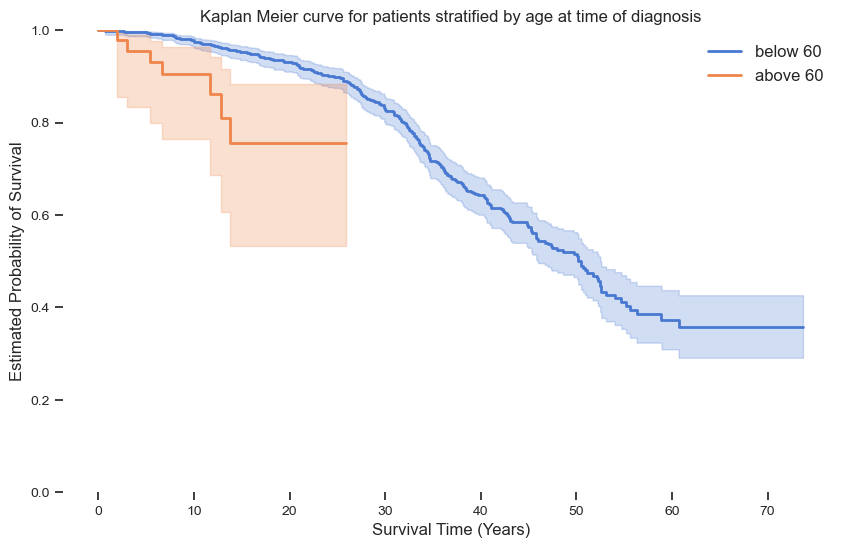

In [301]:
df_final["status"] = df_final["status"].map({
                                                "event": 1,
                                                "censor": 0
                                            })

fig, axes = plt.subplots()

# Instantiating the Kaplan-Meier class
km_lower = KaplanMeierFitter()
km_upper = KaplanMeierFitter()

# fitting Kaplan-Meier for patients below the stratify_age
km_lowerage = km_lower.fit(df_final.loc[~mask,"follow_up_time"], df_final.loc[~mask,"status"])
km_lowerage.plot(label = f"below {age_to_stratify}")

# fitting Kaplan-Meier for patient above the stratify_age
km_upperage = km_upper.fit(df_final.loc[mask,"follow_up_time"], df_final.loc[mask,"status"])
km_upperage.plot(label = f"above {age_to_stratify}", 
                 xlabel = "Survival Time (Years)", 
                 ylabel = "Estimated Probability of Survival")

# fixing figure properties
plt.legend(fontsize = 12, frameon = False)
plt.box(False)
plt.title(f"Kaplan Meier curve for patients stratified by age at time of diagnosis")
plt.ylim([0, 1])
plt.show()

Here, I calculate the median survival times from the output of Kaplan-Meier fitter. <br>
Confidence interval around the median survival times were calculated using the median_survival_times method from lifelines.utils package

In [319]:
# Calculate median survival times and their confidence intervals (using median survival times package from lifelines)
median_upper = km_upperage.median_survival_time_
median_ci_upper = median_survival_times(km_upperage.confidence_interval_).to_numpy()[0]
median_lower = km_lowerage.median_survival_time_
median_ci_lower = median_survival_times(km_lowerage.confidence_interval_).to_numpy()[0]

print(f"Median survival time for patients over {age_to_stratify} years of age at time of diagnosis is {median_upper} {median_ci_upper[0],median_ci_upper[1]}")
print(f"Median survival time for patients below {age_to_stratify} years of age at time of diagnosis is {median_lower} {median_ci_lower[0],median_ci_lower[1]}")


Median survival time for patients over 60 years of age at time of diagnosis is inf (inf, inf)
Median survival time for patients below 60 years of age at time of diagnosis is 50.5 (45.9, 52.5)


**OBSERVATIONs**: <br>

- Patients younger than 60 have an overall higher survival time
- Patient over 60 have been followed up for very short durations. There are not have enough events hence their survival curves never go below 0.5. This leads to the value of inf for median survival times
- The fewer samples for patients with age at diagnosis above 60 also leads to the wider confidence intervals
- Since the data was randomly generated, it does not agree with age-dependent breast cancer biology. In real-scenarios, late-onset breast cancer grows more slowly and is less aggressive [2]

### Statistical Analysis: Logrank test

General form of log-rank test statistic is as follows:
$$W = \frac{X - \mu}{\sqrt{Var(X)}} $$
Here, $X = \sum_{k=1}^K q_{1k}$, where $q_{1k}$ is the number of patients who died at time $d_k$ in group 1 and $\mu = \sum_{k=1}^K \frac{r_{1k}}{r_k}q_k$. This gives the following test statistic for log-rank test

$$W = \frac{\sum_{k=1}^K (q_{1k} - \mu_k)}{\sqrt{\sum_{k=1}^K Var(q_{1k})}} $$

When sample size is large, $W$ follows an approximate normal distribution


In [320]:
# logrank test between survival times of patients above and below the stratifyng age
stats_results = logrank_test(df_final.loc[mask,"follow_up_time"], df_final.loc[~mask,"follow_up_time"], 
                             df_final.loc[mask,"status"], df_final.loc[~mask,"status"])

# Printing summary of results
stats_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          14.12 <0.005     12.51

**OBSERVATION**: <br>
- _p_-value < $\alpha$ (=0.05), hence there is enough evidence to reject the null hypothesis.
- Difference in the survival curves of patients stratified by age at diagnosis = 60 is statistically significant

## HER2 status
1. Calculate the intent to test rate for HER2. 
2. Calculate the tested rate for HER2.
3. Calculate the negativity rate for HER2.

In [304]:
# Connect to the sqlite database
con = sqlite3.connect("techTest.db")
cur = con.cursor()

### Intent to Test Rate

This is the percentage of patients who have an encounter in the biomarker table for the relevant biomarker.
This problem was split into three steps:
1. Subquery1: calculate the number of patients with BC status
2. Subquery2: calculate the number of patients with BC status and HER2
3. Divide the output (*1.0) from two subqueries to get floating point result

In [305]:
sql_query = '''--sql
            SELECT 
            ---sub-query1 to calculate number of distinct patients who have BC status and HER2 biomarker---
                (
                SELECT 
                    COUNT(DISTINCT p1.patient_id)

                FROM 
                    patient  as p1
                LEFT JOIN 
                    diagnosis  as d1 
                        ON p1.patient_id = d1.patient_id
                LEFT JOIN 
                    biomarker b1 
                        ON p1.patient_id = b1.patient_id
                
                WHERE 
                    d1.diagnosis_code LIKE "C50%" ---BC status---
                    AND 
                    b1.biomarker_name = "HER2" ---HER2 biomarker---
                    ) * 1.0 / 
                
            ---sub-query2 to calculate number of distinct patients who have BC status
                (
                SELECT 
                    COUNT(DISTINCT p2.patient_id)

                FROM 
                    patient as p2
                LEFT JOIN 
                    diagnosis as d2 
                        ON p2.patient_id = d2.patient_id
                
                WHERE 
                    d2.diagnosis_code LIKE "C50%"
                    ) AS fraction;
        '''
cur.execute(sql_query)
intent_to_test_rate = cur.fetchone()[0]

print(f"Intent to test rate is {100*intent_to_test_rate :0.1f}%")

Intent to test rate is 81.3%


### Tested Rate
The percentage of patients who have an encounter in the biomarker table for the relevant biomarker with a valid test result

In [306]:
sql_query = '''--sql
            SELECT 
            ---sub-query1 to calculate number of distinct patients who have BC status, HER2 biomarker, and either Positive or Negative test---
                (
                SELECT 
                    COUNT(DISTINCT p1.patient_id)
                
                FROM 
                    patient  as p1
                LEFT JOIN 
                    diagnosis  as d1 
                        ON p1.patient_id = d1.patient_id
                LEFT JOIN 
                    biomarker b1 
                        ON p1.patient_id = b1.patient_id

                WHERE 
                    d1.diagnosis_code LIKE "C50%" ---BC status---
                    AND 
                    b1.biomarker_name = "HER2" ---biomarker HER2---
                    AND 
                    b1.test_result in ("Positive", "Negative") ---Valid test result---
                    ) * 1.0 / 
                
            ---sub-query2 to calculate number of distinct patients who have BC status
                (
                SELECT 
                    COUNT(DISTINCT p2.patient_id)

                FROM 
                    patient as p2
                LEFT JOIN 
                    diagnosis as d2 
                        ON p2.patient_id = d2.patient_id
                
                WHERE 
                    d2.diagnosis_code LIKE "C50%" ---BC status---
                    ) AS fraction;
        '''
cur.execute(sql_query)
test_rate = cur.fetchone()[0]

print(f"Test rate is {100*test_rate :0.1f}%")

Test rate is 55.3%


### Negativity Rate

The percentage of patients who have an encounter in the biomarker table for the relevant biomarker with a negative result.

In [307]:
sql_query = '''--sql
            SELECT 
            ---sub-query1 to calculate number of distinct patients who have BC status, HER2 biomarker, and Negative---
                (
                SELECT 
                    COUNT(DISTINCT p1.patient_id)

                FROM 
                    patient  as p1
                LEFT JOIN 
                    diagnosis  as d1 
                        ON p1.patient_id = d1.patient_id
                LEFT JOIN 
                    biomarker b1 
                        ON p1.patient_id = b1.patient_id
                
                WHERE 
                    d1.diagnosis_code LIKE "C50%" ---BC status---
                    AND 
                    b1.biomarker_name = 'HER2' ---HER2 biomarker---
                    AND 
                    b1.test_result == "Negative" ---Negative test result---
                    ) * 1.0 / 
                
            ---sub-query2 to calculate number of distinct patients who have BC status
                (
                SELECT 
                    COUNT(DISTINCT p2.patient_id)

                FROM 
                    patient as p2
                LEFT JOIN 
                    diagnosis as d2 
                        ON p2.patient_id = d2.patient_id

                WHERE 
                    d2.diagnosis_code LIKE "C50%" ---BC status---
                    ) AS fraction;
        '''
cur.execute(sql_query)
negative_rate = cur.fetchone()[0]

print(f"Negative rate is {100*negative_rate :0.1f}%")

Negative rate is 34.9%


In [308]:
# Close the connection to the database
con.close()

## References

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5242068/ <br>
[2] https://www.sciencedirect.com/science/article/pii/S1040842807001795?via%3Dihub#fig3

## Miscellaneous

In [309]:
con = sqlite3.connect("techTest.db")
cur = con.cursor()
sql_query ='''
            SELECT *
            FROM biomarker
'''
df_biomarker = pd.read_sql_query(sql_query, con)

In [310]:
query_inner = '''--sql
                SELECT 
                    p.patient_id, 
                    d.diagnosis_code,
                    d.diagnosis_date
                    ---b.test_date---

                FROM 
                    patient as p
                LEFT JOIN 
                    diagnosis as d
                    ON p.patient_id = d.patient_id
                    ;
                ---LEFT JOIN---
                 ---   biomarker as b---
                 ---   ON p.patient_id = b.patient_id;---
                '''
df_inner = pd.read_sql_query(query_inner, con)
df_inner.shape

(3026, 3)

In [311]:
df_inner.head()

,patient_id,diagnosis_code,diagnosis_date
0,019d3689-e49a-4f23-8ca1-65379907230b,C50.4,1996-10-05 00:00:00
1,019d3689-e49a-4f23-8ca1-65379907230b,C50.4,2004-10-30 00:00:00
2,019d3689-e49a-4f23-8ca1-65379907230b,C50,2020-06-13 00:00:00
3,81de4975-519f-48c6-a5fa-a57d891495a6,C50,1986-04-01 00:00:00
4,dbed4b3e-33ba-4856-a78d-3db6d211def8,I10,1993-09-08 00:00:00


In [312]:
df_filter = df_inner[df_inner["diagnosis_code"].str.contains('C50.*')]
df_filter2 = df_filter.drop_duplicates("patient_id")
df_filter2.shape

(941, 3)

In [313]:
query_trial= '''--sql
                SELECT 
                    p.patient_id, 
                    date(p.dod) as dod,  
                    STRFTIME("%Y", MIN(d.diagnosis_date)) - STRFTIME("%Y",p.dob) as age_at_diagnosis, 
                    date(MIN(d.diagnosis_date)) as first_diagnosis_date, 
                    sub_dates.last_diagnosis_date, 
                    sub_dates.last_test_date

                ---Patient joined to Diagnosis joined to Biomarker on key patient_id---
                FROM 
                    patient as p 
                LEFT JOIN 
                    diagnosis as d
                        ON p.patient_id = d.patient_id
                LEFT JOIN
                    (SELECT 
                        sub_p.patient_id, 
                        date(MAX(sub_d.diagnosis_date)) as last_diagnosis_date,
                        date(MAX(sub_b.test_date)) as last_test_date
                    FROM
                        patient as sub_p
                    LEFT JOIN
                        diagnosis as sub_d 
                            ON sub_p.patient_id = sub_d.patient_id
                    LEFT JOIN
                        biomarker as sub_b
                            ON sub_p.patient_id = sub_b.patient_id
                    GROUP BY
                        sub_p.patient_id
                    ) as sub_dates
                    ON p.patient_id = sub_dates.patient_id 

                WHERE  
                    d.diagnosis_code LIKE "C50%"
                        
                GROUP BY 
                    p.patient_id;

                '''
df_patient = pd.read_sql_query(query_trial, con)
#df_patient[["dob", "dod"]] = pd.to_datetime(df_patient[["dob","dod"]])
print(f"{df_patient.shape[0]}x{df_patient.shape[1]}")
df_patient.head()


941x6


,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date
0,0004477e-31f7-4704-a123-2b68dd64aaed,2008-03-20,59,2019-11-04,2019-11-04,2011-12-03
1,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,50,1993-04-07,2019-05-20,2004-12-19
2,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,21,1986-06-02,2021-10-13,2023-12-29
3,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,30,1996-10-05,2020-06-13,2018-03-10
4,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,26,1977-01-16,1981-10-28,1995-12-08


In [314]:
query_test = '''--sql
                    SELECT 
                        sub_p.patient_id, sub_d.diagnosis_code
                        ---date(MAX(sub_d.diagnosis_date)) as last_dianosis_date,
                        ---date(MAX(sub_b.test_date)) as last_test_date
                    FROM
                        patient as sub_p
                    LEFT JOIN
                        diagnosis as sub_d 
                            ON sub_p.patient_id = sub_d.patient_id
                    LEFT JOIN
                        biomarker as sub_b
                            ON sub_p.patient_id = sub_b.patient_id
                    ---GROUP BY
                    ---    sub_p.patient_id

'''

df_inner = pd.read_sql_query(query_test, con)
print(f"{df_inner.shape[0]}x{df_inner.shape[1]}")

df_inner["diagnosis_code"].str.match("C50.*").sum()

9258x2


7352

In [315]:
df_inner[df_inner["diagnosis_code"].str.match("C50.*")].groupby(["patient_id"]).count()

,diagnosis_code
patient_id,
0004477e-31f7-4704-a123-2b68dd64aaed,3
0022fa14-8260-4b11-88cd-3fa066ede851,12
0183e236-7892-4aa9-8b7f-10f12676f1ec,16
019d3689-e49a-4f23-8ca1-65379907230b,3
01d468fc-55b8-45e3-8eca-dcb7a6185f28,8
...,...
fdd8e833-ca01-4ce5-8ca9-30ec3ba404d8,5
fe0c8392-f97d-4097-b0f2-a726a17cadd5,3
fe3690ce-1b13-4bfa-b65e-71d385aeb8c1,20


*Do patients have multiple date of births* - No, there are 1000 patients

In [316]:
#query to group data by patient_id and compare min and max of date of birth

cur.execute('''--sql
            
                SELECT SUM(same_dob) as total_same_dob, COUNT(*) as total_rows

                ---Sub-query to count patients whesre MIN(dob) is equal to MAX(dob)---
                FROM (
                    SELECT COUNT(*) as same_dob
                    FROM Patient
                    GROUP BY patient_id
                    ---HAVING MIN(dob) = MAX(dob)---
                    );
                
            ''')

total_same_dob, total_rows = cur.fetchone()

# assert statement to check whether all patients have identical dob
assert total_same_dob == total_rows, "A patient has multiple dobs"

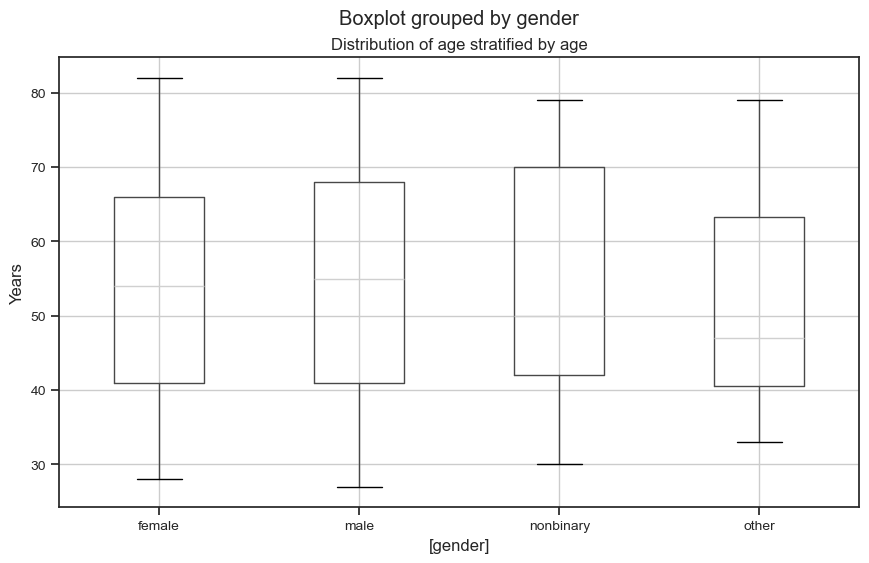

In [317]:
query_age = '''
                SELECT STRFTIME("%Y",dod) - STRFTIME("%Y",dob) as age, gender
                FROM patient
                WHERE gender != "NULL"
                '''
df_age = pd.read_sql_query(query_age, con)
df_age.boxplot(by = "gender")
plt.title("Distribution of age stratified by age")
plt.ylabel("Years")
plt.show()

In [318]:
df_final["gender"].count_values()

KeyError: 'gender'

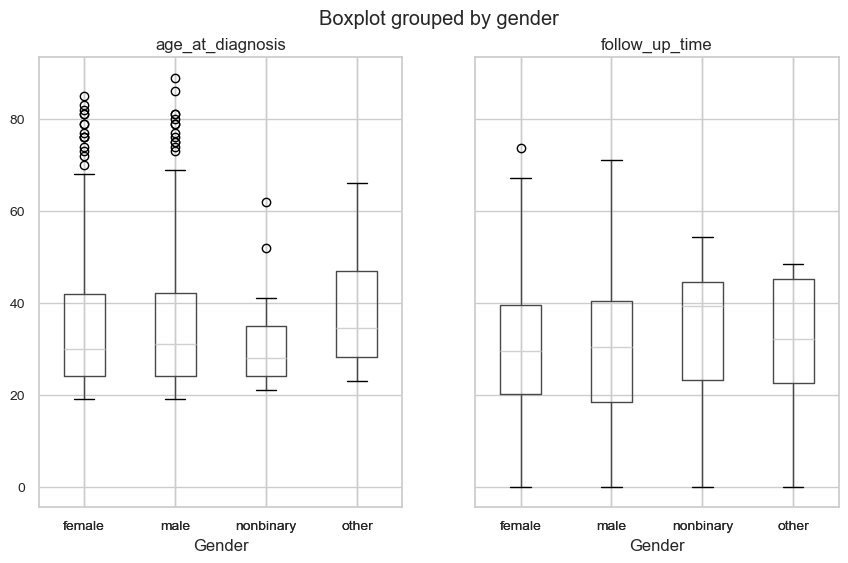

In [ ]:
df_removenull = df[df["gender"]!="NULL"]
df_removenull[["follow_up_time", "age_at_diagnosis", "gender"]].boxplot(by = "gender", xlabel = "Gender")
fig.tight_layout(pad = 2)
plt.show()

### Testing HER2 status with pandas

In [ ]:
sql_query = '''--sql
                SELECT p.patient_id, b.biomarker_name, b.test_result, b.biomarker_test_type
                
                ---JOIN patient and biomarker table---
                FROM 
                    patient as p 
                LEFT JOIN 
                    biomarker as b 
                        on p.patient_id = b.patient_id
   
                ---sub-query to select patients with breast cancer with diagnosis_code starting with C50---
                WHERE 
                    p.patient_id IN (
                        SELECT 
                            patient_id
                        FROM 
                            diagnosis
                        WHERE 
                            diagnosis_code LIKE "C50%"
                        );
            '''

df_her2_status = pd.read_sql_query(sql_query, con)
print(df_her2_status.shape)
print(f"denominator: {len(df_her2_status['patient_id'].unique())}")
print(f"Intention to treat: {(df_her2_status['biomarker_name']=='HER2').sum():0.2f}")
print(f"Tested_rate: {((df_her2_status['biomarker_name']=='HER2') & (df_her2_status['biomarker_test_type'].isin(['PCR','IHC']))).sum():0.2f}")
print(f"Tested_rate: {((df_her2_status['biomarker_name']=='HER2') & (df_her2_status['test_result'] == 'Negative')).sum():0.2f}")
df_her2_status["test_result"].unique()


(2873, 4)
denominator: 941
Intention to treat: 1426.00
Tested_rate: 900.00
Tested_rate: 411.00


array(['Positive', 'Negative', 'Unknown', 'Equivocal', 'Inconclusive',
       'NA'], dtype=object)

In [ ]:
df_her2_status[df_her2_status["biomarker_name"]=="HER2"].groupby("patient_id").count()

,biomarker_name,test_result,biomarker_test_type
patient_id,,,
0004477e-31f7-4704-a123-2b68dd64aaed,1,1,1
0022fa14-8260-4b11-88cd-3fa066ede851,1,1,1
0183e236-7892-4aa9-8b7f-10f12676f1ec,1,1,1
01d468fc-55b8-45e3-8eca-dcb7a6185f28,3,3,3
022ff2bf-19d7-4c4d-8410-a91773ad24f2,4,4,4
...,...,...,...
fdd8e833-ca01-4ce5-8ca9-30ec3ba404d8,3,3,3
fe0c8392-f97d-4097-b0f2-a726a17cadd5,1,1,1
fe3690ce-1b13-4bfa-b65e-71d385aeb8c1,2,2,2


In [ ]:
765/941

0.8129649309245484

In [ ]:
df_her2_status[(df_her2_status["biomarker_name"]=="HER2") & (df_her2_status["test_result"].isin(["Positive", "Negative"])) ].groupby("patient_id").count()

,biomarker_name,test_result,biomarker_test_type
patient_id,,,
0004477e-31f7-4704-a123-2b68dd64aaed,1,1,1
0022fa14-8260-4b11-88cd-3fa066ede851,1,1,1
01d468fc-55b8-45e3-8eca-dcb7a6185f28,3,3,3
022ff2bf-19d7-4c4d-8410-a91773ad24f2,2,2,2
023f0abd-4675-4b59-96e9-5b5ca052560a,1,1,1
...,...,...,...
fd0c8dae-b4ef-4ed6-917c-4ac27aa67635,3,3,3
fd6ec646-f3ae-4552-8b63-aa10255f5095,2,2,2
fdd8e833-ca01-4ce5-8ca9-30ec3ba404d8,2,2,2


In [ ]:
520/941

0.5526036131774708

In [ ]:
df_her2_status[(df_her2_status["biomarker_name"]=="HER2") & (df_her2_status["test_result"]== "Negative") ].groupby("patient_id").count()

,biomarker_name,test_result,biomarker_test_type
patient_id,,,
0004477e-31f7-4704-a123-2b68dd64aaed,1,1,1
01d468fc-55b8-45e3-8eca-dcb7a6185f28,2,2,2
022ff2bf-19d7-4c4d-8410-a91773ad24f2,1,1,1
023f0abd-4675-4b59-96e9-5b5ca052560a,1,1,1
05720cba-7eda-4f7e-b0e8-bcc1022a1702,1,1,1
...,...,...,...
fccd5a49-ba76-4d1f-a344-7df398462f60,1,1,1
fd0c8dae-b4ef-4ed6-917c-4ac27aa67635,2,2,2
fd6ec646-f3ae-4552-8b63-aa10255f5095,2,2,2


In [ ]:
328/941

0.3485653560042508

### Biomarker test for diagnostics

In [ ]:
condition = df_biomarker["patient_id"].isin(df_diagnostic_biomarker["patient_id"])
(df_biomarker.loc[condition, "test_result"] == "Positive").sum()

76